In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

In [3]:
url = 'https://ds.codeup.com/saas.csv'
df = pd.read_csv(url)
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
# Preparation of SAAS data
df.columns = [col.lower() for col in df]

In [5]:
df.month_invoiced = pd.to_datetime(df.month_invoiced)

In [6]:
# Changing subscription_type and amount to correct type (int)
df.subscription_type = df.subscription_type.astype(int)
df.amount = df.amount.astype(int)

In [7]:
# Setting datetime as index
df = df.set_index('month_invoiced')

<AxesSubplot:xlabel='month_invoiced'>

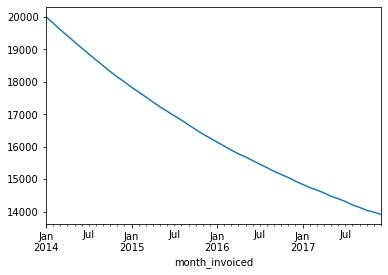

In [8]:
# How many observations /month?
df.resample('M').size().plot()


[Text(0.5, 1.0, 'Revenue over time'),
 Text(0, 0.5, 'Revenue'),
 Text(0.5, 0, '')]

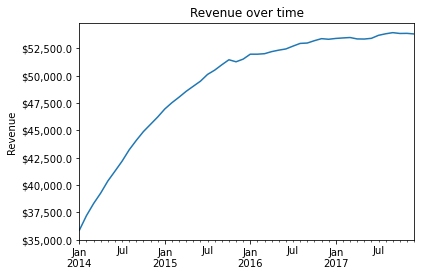

In [9]:
# Monthly revenue over time
from matplotlib.dates import DateFormatter
from matplotlib.ticker import StrMethodFormatter
ax = df.resample('M').amount.sum().plot()
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))
ax.set(title='Revenue over time', ylabel='Revenue', xlabel='')

In [10]:
# Focusing on revenue by month
df = df.resample('M')[['amount']].sum()

### For splitting:
1. We will use the training proportion method to split.
1. Identify the total length of the dataframe and multiply by train_prop to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data. (x = train_prop * 100)
1. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.
1. Return train and test dataframes.

In [11]:
int(len(df) * .5)

24

In [12]:
# setting train to 50% of total
train_s = int(len(df) * .5)
train_s

24

In [13]:
# validate to 30%
validate_s = int(len(df) * .3)

In [14]:
# test to remainder
test_s = int(len(df) - train_s - validate_s)
test_s

10

In [15]:
# Set end for validate
validate_end_index = train_s + validate_s

In [16]:
# Using values to split data
train = df[:train_s]
validate = df[train_s:validate_end_index]
test = df[validate_end_index:]

In [17]:
train.columns

Index(['amount'], dtype='object')

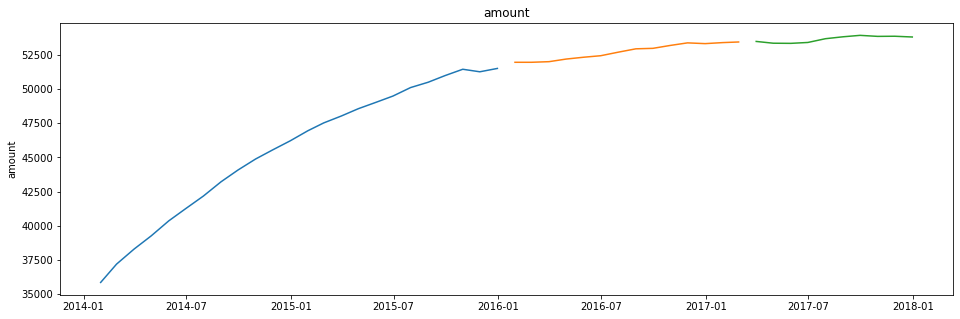

In [18]:
for col in train.columns:
    plt.figure(figsize=(16,5))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [19]:
# Useful functions for evaluation

In [20]:
# Compute the Mean Squared Error and the Root Mean Squared Error
def evaluate(target_var):
    '''
    Take actual values of target_var from validate, and predicted values stoared in yhat_df, 
    compute the rmse, rounding to 0 decimal places. Returns rmse.
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [21]:
# Use evaluate function and also plot train and test values with predicted values in order to compare performance
def plot_and_eval(target_var):
    '''
    Takes in target var name (str), returns a plot of values of train for that var, and the predicted values from yhat_df.
    Labels the rmse.
    '''
    plt.figure(figsize=(13,5))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [22]:
# Function that stores the rmse so that we can compare them at the end
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [23]:
# Creating an empty df
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


### Forecasting:
'Predicting' time series data
1. Last Observed Value: Future will like like the now.
2. Simple Average: Future will look, on average, like history.
3. Moving Average: Future will look, on average, like recent history.
4. Holt's Linear Trend. 
5. Previous Cycle.

#### Last Observed Value

In [24]:
train['amount'][-1:][0]

51505

In [25]:
# Take last item from amount and assign to var
amount = train['amount'][-1:][0]

In [26]:
yhat_df = pd.DataFrame({'amount': [amount]},
                      index=validate.index)
yhat_df.head()

,amount
month_invoiced,
2016-01-31,51505
2016-02-29,51505
2016-03-31,51505
2016-04-30,51505
2016-05-31,51505


In [27]:
yhat_df.describe()

,amount
count,14.0
mean,51505.0
std,0.0
min,51505.0
25%,51505.0
50%,51505.0
75%,51505.0
max,51505.0


In [28]:
# Notice that every predicted value is the same

amount -- RMSE: 1343


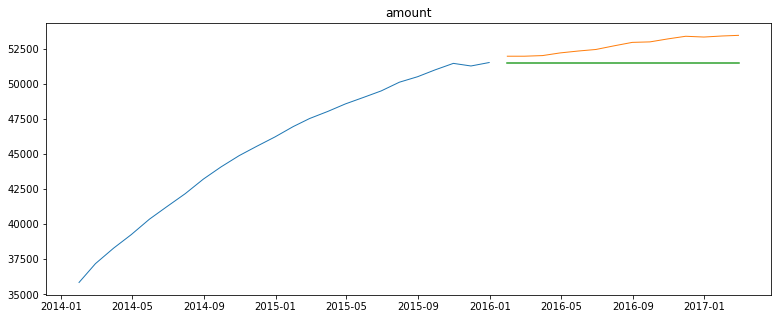

In [29]:
# Plotting actual vs predicted
plot_and_eval('amount')

amount -- RMSE: 1343


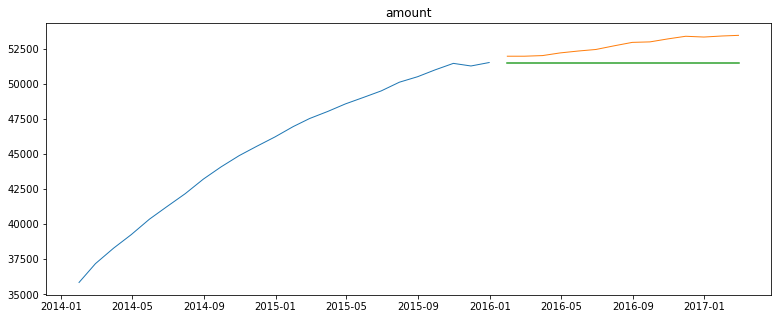

In [30]:
for col in train.columns:
    plot_and_eval(col)

In [31]:
# Evaluation w/ MSE and RMSE
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value',
                            target_var = col)
eval_df

/var/folders/pt/3m3r1rq55pdgzpmnqzkdjb240000gn/T/ipykernel_2619/2810628987.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)


,model_type,target_var,rmse
0,last_observed_value,amount,1343.0


#### Simple Average

In [32]:
amount = round(train['amount'].mean(), 2)

In [33]:
# Apply predictions to observations
def make_predictions(amount=None):
    yhat_df = pd.DataFrame({'amount': [amount]},
                          index=validate.index)
    return yhat_df

In [34]:
yhat_df = make_predictions(amount)

amount -- RMSE: 7181


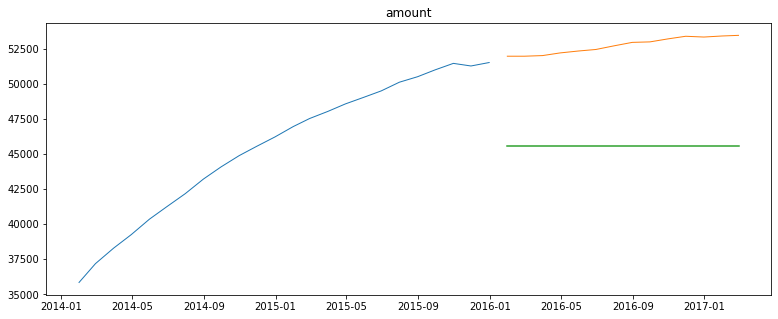

In [35]:
# Plotting actual vs predicted values
for col in train.columns:
    plot_and_eval(col)

In [36]:
# Evaluate using MSE and RMSE, add to eval_df
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_avg',
                            target_var = col)
eval_df

/var/folders/pt/3m3r1rq55pdgzpmnqzkdjb240000gn/T/ipykernel_2619/2810628987.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)


,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple_avg,amount,7181.0


#### Moving Average

In [37]:
# Using example of 3 month average to forecast

In [38]:
period = 3
train['amount'].rolling(period).mean()[-1]

51403.333333333336

In [40]:
period = 3
# Take the 90 day rolling avg, then take the last element and that will be the one that is used to forecast
amount = round(train['amount'].rolling(period).mean()[-1], 2)

In [41]:
yhat_df = make_predictions(amount)
yhat_df.head()

,amount
month_invoiced,
2016-01-31,51403.33
2016-02-29,51403.33
2016-03-31,51403.33
2016-04-30,51403.33
2016-05-31,51403.33


amount -- RMSE: 1436


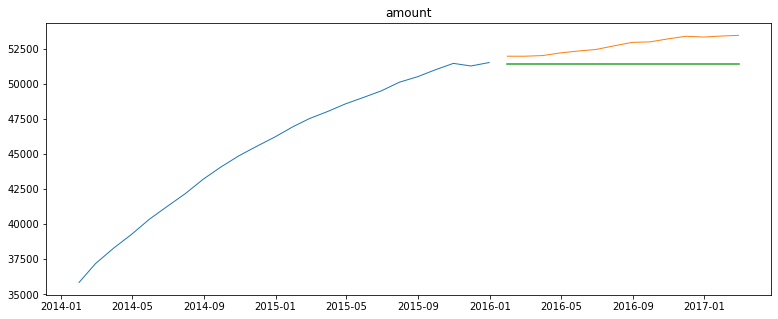

In [42]:
# Plot actual v predicted
for col in train.columns:
    plot_and_eval(col)

In [43]:
for col in train.columns:
    eval_df = append_eval_df(model_type= '3_month_moving_avg', target_var=col)
eval_df

/var/folders/pt/3m3r1rq55pdgzpmnqzkdjb240000gn/T/ipykernel_2619/2810628987.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)


,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple_avg,amount,7181.0
2,3_month_moving_avg,amount,1436.0


In [44]:
# Adding in other period times
periods = [1, 2, 3, 4, 10, 12]
for p in periods:
    amount = round(train['amount'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions(amount)
    model_type = str(p) + '_month_moving_average'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, target_var = col)

/var/folders/pt/3m3r1rq55pdgzpmnqzkdjb240000gn/T/ipykernel_2619/2810628987.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)
/var/folders/pt/3m3r1rq55pdgzpmnqzkdjb240000gn/T/ipykernel_2619/2810628987.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)
/var/folders/pt/3m3r1rq55pdgzpmnqzkdjb240000gn/T/ipykernel_2619/2810628987.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)
/var/folders/pt/3m3r1rq55pdgzpmnqzkdjb240000gn/T/ipykernel_2619/2810628987.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

In [45]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple_avg,amount,7181.0
2,3_month_moving_avg,amount,1436.0
3,1_month_moving_average,amount,1343.0
4,2_month_moving_average,amount,1455.0
5,3_month_moving_average,amount,1436.0
6,4_month_moving_average,amount,1533.0
7,10_month_moving_average,amount,2696.0
8,12_month_moving_average,amount,3164.0


In [48]:
# Finding the lowest (best) value
min_rmse = eval_df[eval_df.target_var == 'amount']['rmse'].min()

In [49]:
min_rmse

1343.0

In [51]:
eval_df[eval_df.rmse == min_rmse]

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
3,1_month_moving_average,amount,1343.0


#### Holt's Linear Trend

Exponential smoothing applied to both the average and the trend (slope).

- α
 / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.
- β
 / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values.

In [52]:
# Seasonal Decomposition (looking at this for each target)
import statsmodels.api as sm

amount 



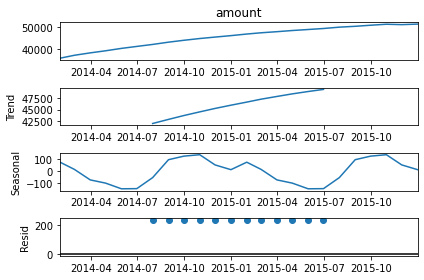

In [53]:
print(col, '\n')
sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
plt.show()

#### Basic Holt's Linear Trend

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions.

Holt:

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)
- damped 
ϕ
 = True/False: with Holt, forecasts will increase or decrease indefinitely into the future. To avoid this, use the Damped trend method which has a damping parameter 0< ϕ <1.
fit:

- smoothing_level (
α
): value between (0,1)
- smoothing_slope (
β
): value between (0,1)
- optimized: use the auto-optimization that allow statsmodels to automatically find an optimized value for us.

In [54]:
train.columns

Index(['amount'], dtype='object')

In [55]:
col = 'amount'
model = Holt(train[col], exponential=False, damped=True)

/var/folders/pt/3m3r1rq55pdgzpmnqzkdjb240000gn/T/ipykernel_2619/522252063.py:2: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  model = Holt(train[col], exponential=False, damped=True)


In [56]:
model = model.fit(optimized=True)

In [57]:
yhat_items = model.predict(start = validate.index[0], end = validate.index[-1])

In [58]:
yhat_items

2016-01-31    51748.561196
2016-02-29    51961.889989
2016-03-31    52173.186755
2016-04-30    52382.470850
2016-05-31    52589.761446
2016-06-30    52795.077530
2016-07-31    52998.437910
2016-08-31    53199.861217
2016-09-30    53399.365900
2016-10-31    53596.970235
2016-11-30    53792.692324
2016-12-31    53986.550096
2017-01-31    54178.561308
2017-02-28    54368.743551
Freq: M, dtype: float64

In [59]:
yhat_df[col] = round(yhat_items, 2)

amount -- RMSE: 456


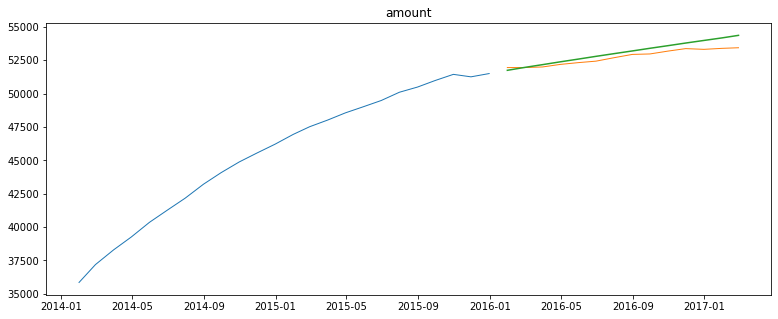

In [60]:
plot_and_eval(target_var = col)

In [61]:
eval_df = append_eval_df(model_type = 'holts_opt', target_var=col)

/var/folders/pt/3m3r1rq55pdgzpmnqzkdjb240000gn/T/ipykernel_2619/2810628987.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)


In [62]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
9,holts_opt,amount,456.0
0,last_observed_value,amount,1343.0
3,1_month_moving_average,amount,1343.0
2,3_month_moving_avg,amount,1436.0
5,3_month_moving_average,amount,1436.0
4,2_month_moving_average,amount,1455.0
6,4_month_moving_average,amount,1533.0
7,10_month_moving_average,amount,2696.0
8,12_month_moving_average,amount,3164.0
1,simple_avg,amount,7181.0


#### Predict based on previous cycle

In [63]:
# re-split the data
df.index

DatetimeIndex(['2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='month_invoiced', freq='M')

The general idea:
1. Compute the 365 average year over year differences from 2013 through 2015
2. Add that average delta to the values during 2015.
3. Set the index in your yhat dataframe to represent the dates those predictions are make for.

In [64]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

/var/folders/pt/3m3r1rq55pdgzpmnqzkdjb240000gn/T/ipykernel_2619/1482138165.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  validate = df['2016']
/var/folders/pt/3m3r1rq55pdgzpmnqzkdjb240000gn/T/ipykernel_2619/1482138165.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  test = df['2017']


In [65]:
# Making predictions, year over year diff from 2013-2014, take mean, add to each value in 2015
yhat_df = train['2015'] + train.diff(12).mean()

/var/folders/pt/3m3r1rq55pdgzpmnqzkdjb240000gn/T/ipykernel_2619/469416008.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  yhat_df = train['2015'] + train.diff(12).mean()


In [66]:
train.loc['2015'].head()

,amount
month_invoiced,
2015-01-31,46945
2015-02-28,47520
2015-03-31,48025
2015-04-30,48560
2015-05-31,49025


In [67]:
# Prediction for 2016 (2015 value + year over year avg diff)
pd.concat([yhat_df.head(1), validate.head(1)])

,amount
month_invoiced,
2015-01-31,55033.75
2016-01-31,51955.00


In [68]:
yhat_df.index = validate.index

amount -- RMSE: 5192


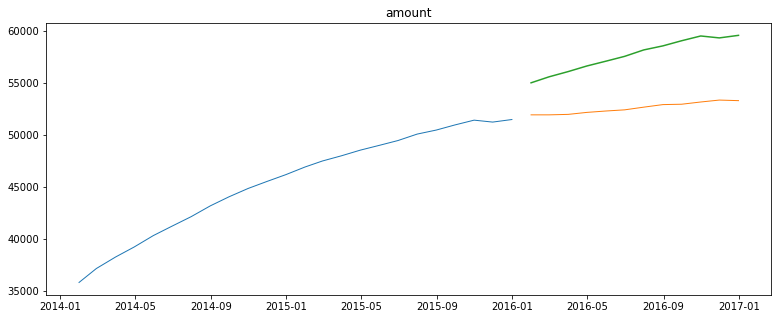

/var/folders/pt/3m3r1rq55pdgzpmnqzkdjb240000gn/T/ipykernel_2619/2810628987.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return eval_df.append(d, ignore_index = True)


In [70]:
plot_and_eval(target_var=col)
eval_df = append_eval_df(model_type = 'previous_year', target_var = col)

In [71]:
# Which did the best?

In [72]:
min_rmse = eval_df['rmse'].min()

In [74]:
eval_df[(eval_df.rmse == min_rmse)]

,model_type,target_var,rmse
9,holts_opt,amount,456.0


In [75]:
# Test on out of sample data
yhat_items = model.predict(start=test.index[0], end=test.index[-1])

In [76]:
yhat_df = pd.DataFrame(index=test.index, columns=test.columns)
yhat_df.amount = yhat_items

In [77]:
yhat_df

,amount
month_invoiced,
2017-01-31,54178.561308
2017-02-28,54368.743551
2017-03-31,54557.114245
2017-04-30,54743.690647
2017-05-31,54928.489846
2017-06-30,55111.528773
2017-07-31,55292.824193
2017-08-31,55472.392716
2017-09-30,55650.250788


In [78]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [79]:
rmse_amount = sqrt(mean_squared_error(test['amount'], yhat_df['amount']))

In [80]:
print('rmse-amount: ', rmse_amount)

rmse-amount:  1643.756925583056


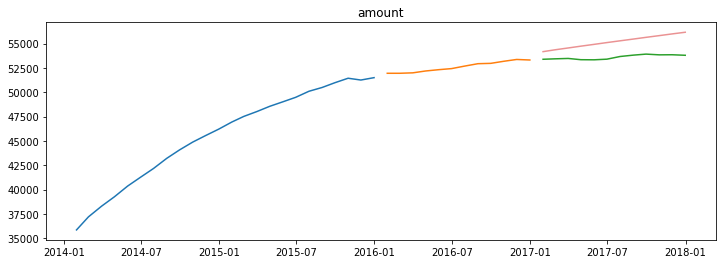

In [81]:
final_plot(col)

In [82]:
# Predicting 2018
yhat_df.index = test.index + pd.Timedelta('1Y')
yhat = model.predict(start=test.index[0], end=test.index[-1])

/opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [83]:
yhat

2017-01-31    54178.561308
2017-02-28    54368.743551
2017-03-31    54557.114245
2017-04-30    54743.690647
2017-05-31    54928.489846
2017-06-30    55111.528773
2017-07-31    55292.824193
2017-08-31    55472.392716
2017-09-30    55650.250788
2017-10-31    55826.414704
2017-11-30    56000.900601
2017-12-31    56173.724463
Freq: M, dtype: float64

In [84]:
yhat_df.amount = yhat.values

In [85]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5, label='projection')
    plt.title(target_var)
    plt.legend()
    plt.show()

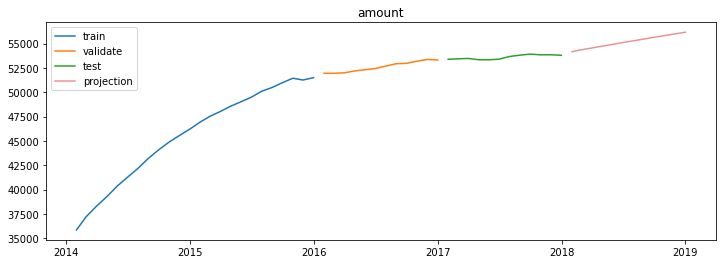

In [86]:
for col in train.columns:
    final_plot(col)

## I need to go back and review this...I typed it from the instruction review but I need to go back and digest it better bc there are a lot of components here I am still lost on in terms of piecing it all together. 